In [1]:
import os
import numpy as np
import scipy.stats
import netCDF4 as nc
import re
import itertools
import ot
import concurrent.futures
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 300

try:
    experiment_folder = os.environ['AZEBAN_EXPERIMENT_DIR']
except:
    experiment_folder = '/home/tobias/Programmieren/azeban/build'

In [2]:
def read_u(path, time, N=None, samples=None):
    files = os.listdir(path)
    reg = re.compile(f'^sample_\\d+_time_{time}.nc$')
    u_files = list(filter(reg.search, files))
    if samples is None:
        samples = list(set(list(sorted([int(f.split('_')[1])for f in u_files]))))
    with nc.Dataset(f'{path}/sample_{samples[0]}_time_{time}.nc', 'r') as f:
        N_data = f.dimensions['N'].size
    if N is None:
        N = N_data
    else:
        N = min(N, N_data)
    u = np.empty((3, N, N, N, len(samples)))
    interpolated_indices = [int(i*N_data/N) for i in range(N)]
    for i, sample in enumerate(samples):
        with nc.Dataset(f'{path}/sample_{sample}_time_{time}.nc', 'r') as f:
            u[0,:,:,:,i] = f['u'][interpolated_indices, interpolated_indices, interpolated_indices]
            u[1,:,:,:,i] = f['v'][interpolated_indices, interpolated_indices, interpolated_indices]
            u[2,:,:,:,i] = f['w'][interpolated_indices, interpolated_indices, interpolated_indices]
    return u

def _wasserstein_distance(args):
    u1, u2, xs, xt, k, N, point = args
    dist = 0
    for j in range(k):
        xs[:,j] = u1[point[j][0],point[j][1],point[j][2],:]
        xt[:,j] = u2[point[j][0],point[j][1],point[j][2],:]
        d = ot.dist(xs, xt, metric='euclidean')
        G0 = ot.emd([], [], d)
        dist += np.sum(G0*d) / (N**(3*k))
    return dist

def k_point_wasserstein_distance(u1, u2, k):
    dist = 0
    N = u1.shape[0]
    M = u1.shape[-1]
    xs = np.empty((M, k))
    xt = np.empty((M, k))
    xiter = itertools.product(range(N), repeat=3)
    points = list(itertools.product(xiter, repeat=k))
    Np = len(points)
    with concurrent.futures.ProcessPoolExecutor() as p:
        chunksize = max(1, Np//(16*os.cpu_count()))
        print(f'Using chunksize={chunksize} for {Np} points')
        dist = sum(p.map(_wasserstein_distance,
                         zip([u1]*Np, [u2]*Np, [xs]*Np, [xt]*Np, [k]*Np, [N]*Np, points),
                         chunksize=chunksize))
    return dist

In [3]:
def plot_wasserstein(paths, Ns, k, time, N, save_name=None, samples=None):
    errors = []
    for (path_coarse, N_coarse), (path_fine, N_fine) in zip(zip(paths[:-1], Ns[:-1]), zip(paths[1:], Ns[1:])):
        u_coarse = read_u(path_coarse, time, N=N, samples=samples)
        u_fine = read_u(path_fine, time, N=N, samples=samples)
        dist = 0
        for i in range(3):
            dist += k_point_wasserstein_distance(u_coarse[i], u_fine[i], k)
        print(f'W_1(\\nu^{{{k},{N_coarse}}}, \\nu^{{{k},{N_fine}}}) = {dist}')
        errors.append(dist)
    plt.loglog(Ns[:-1], errors, '-o')
    plt.xlabel('N')
    plt.ylabel(f'$W_1(\\nu^{{{k},N}}, \\nu^{{{k},2N}})$')
    plt.title(f'Wasserstein Convergence for $\\nu^{{{k}}}$')
    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

# Wasserstein Convergence of Brownian Bridges

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.2816130562143372
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.26875704422575664


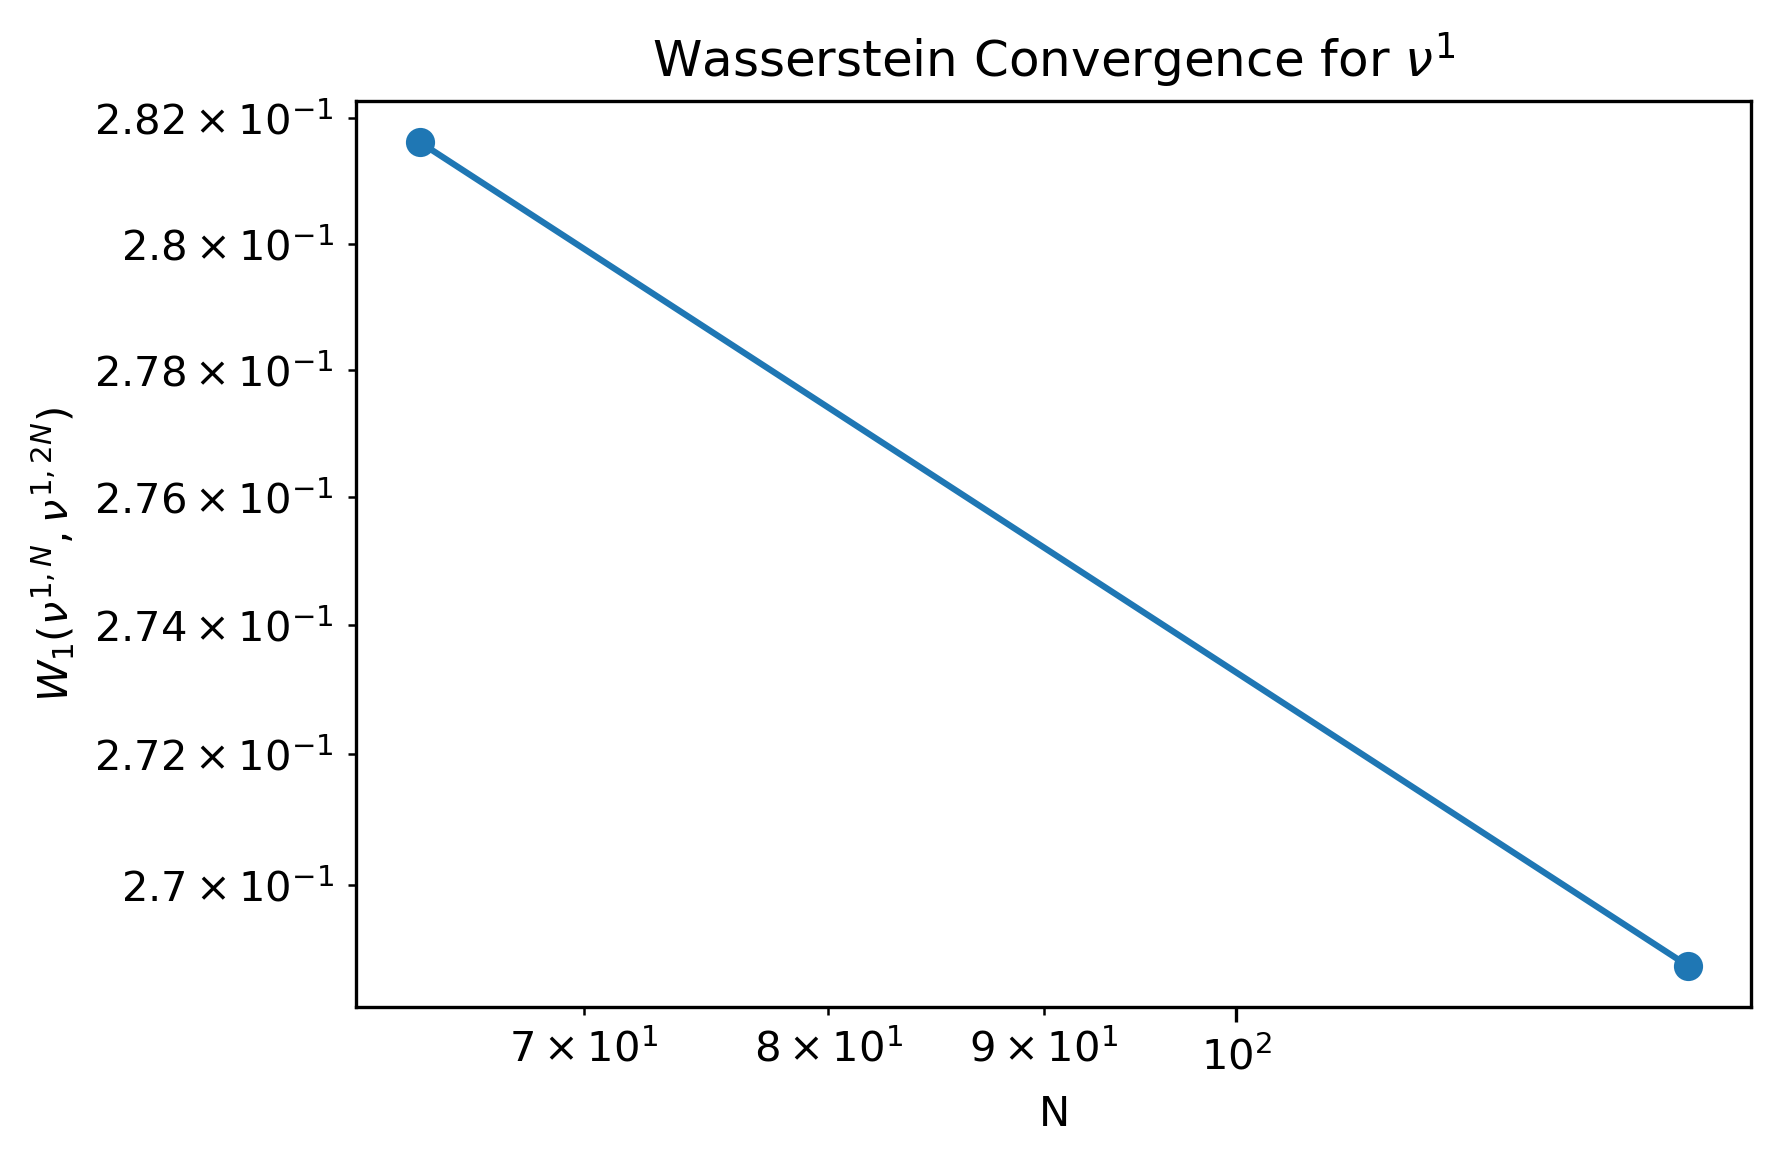

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 1.085626367765058
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 1.0470550315043314


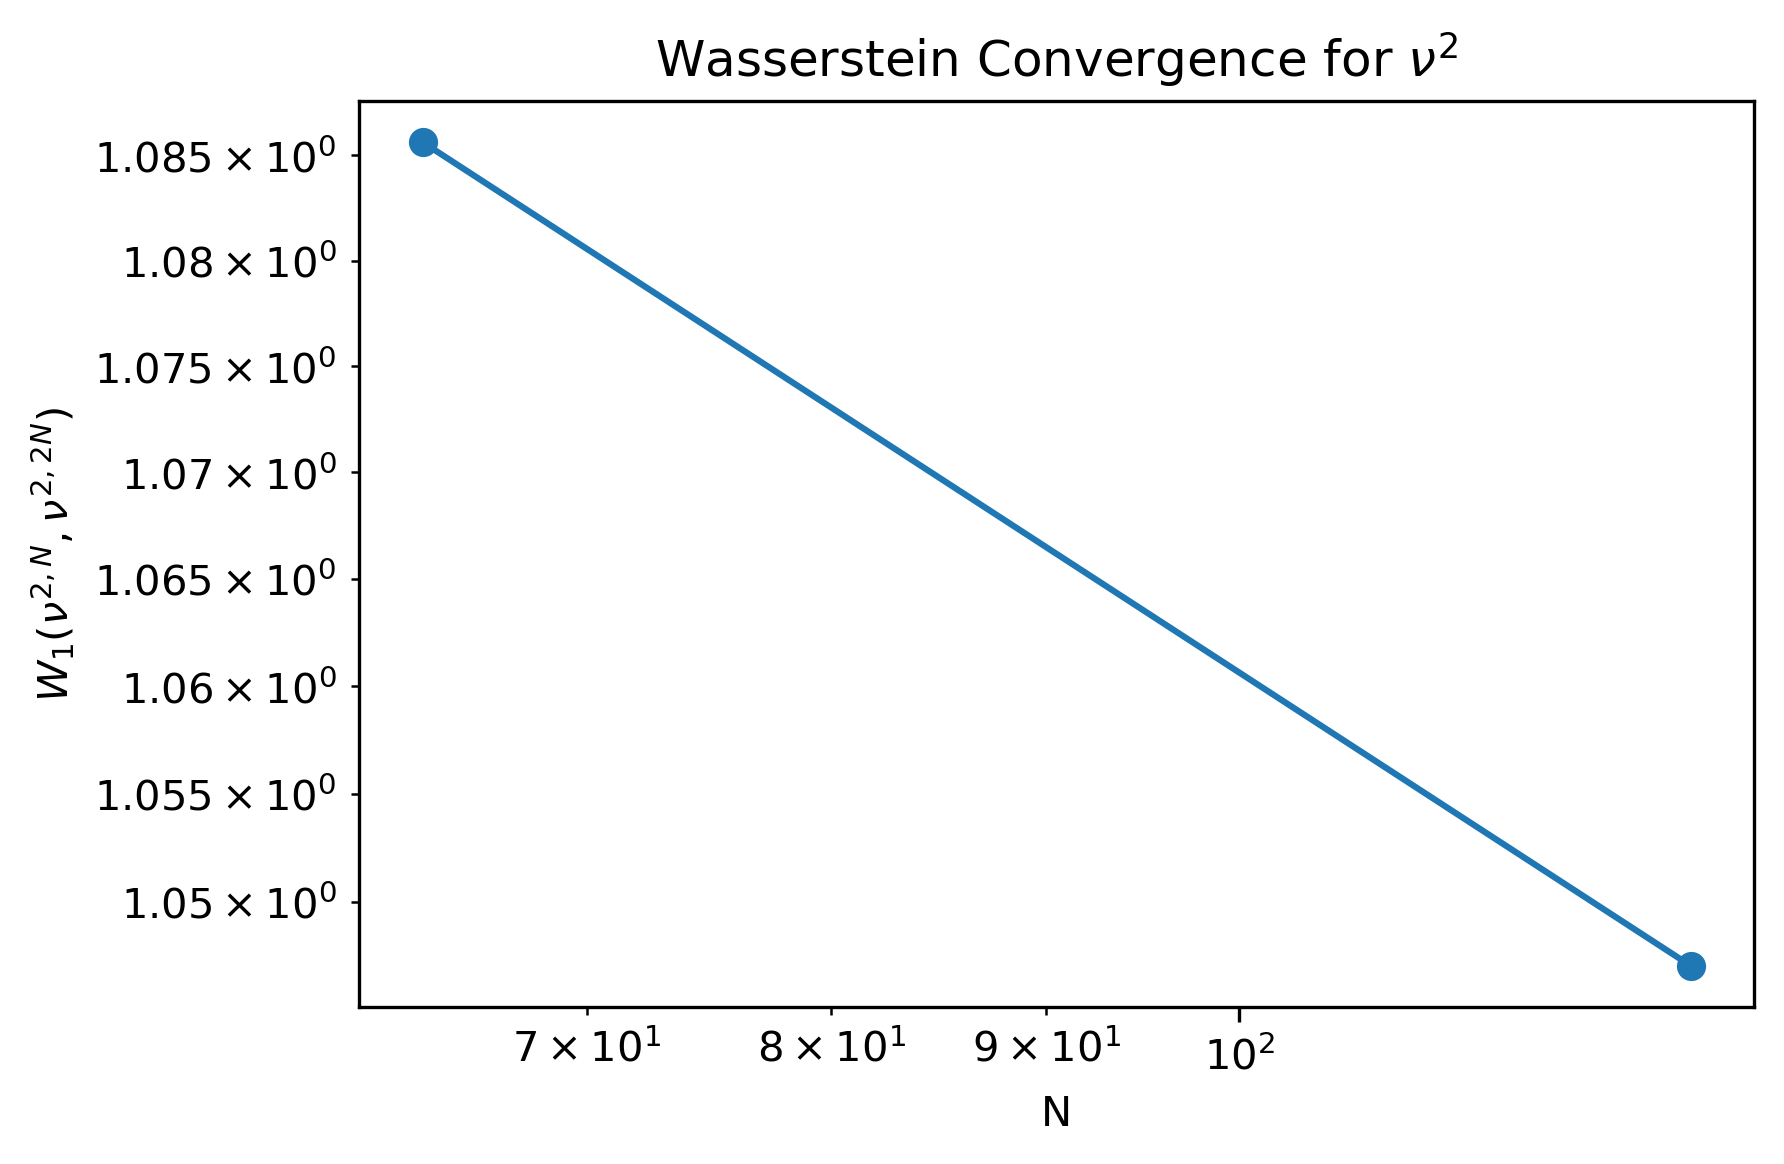

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.2322418158814253
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.23376410090393634


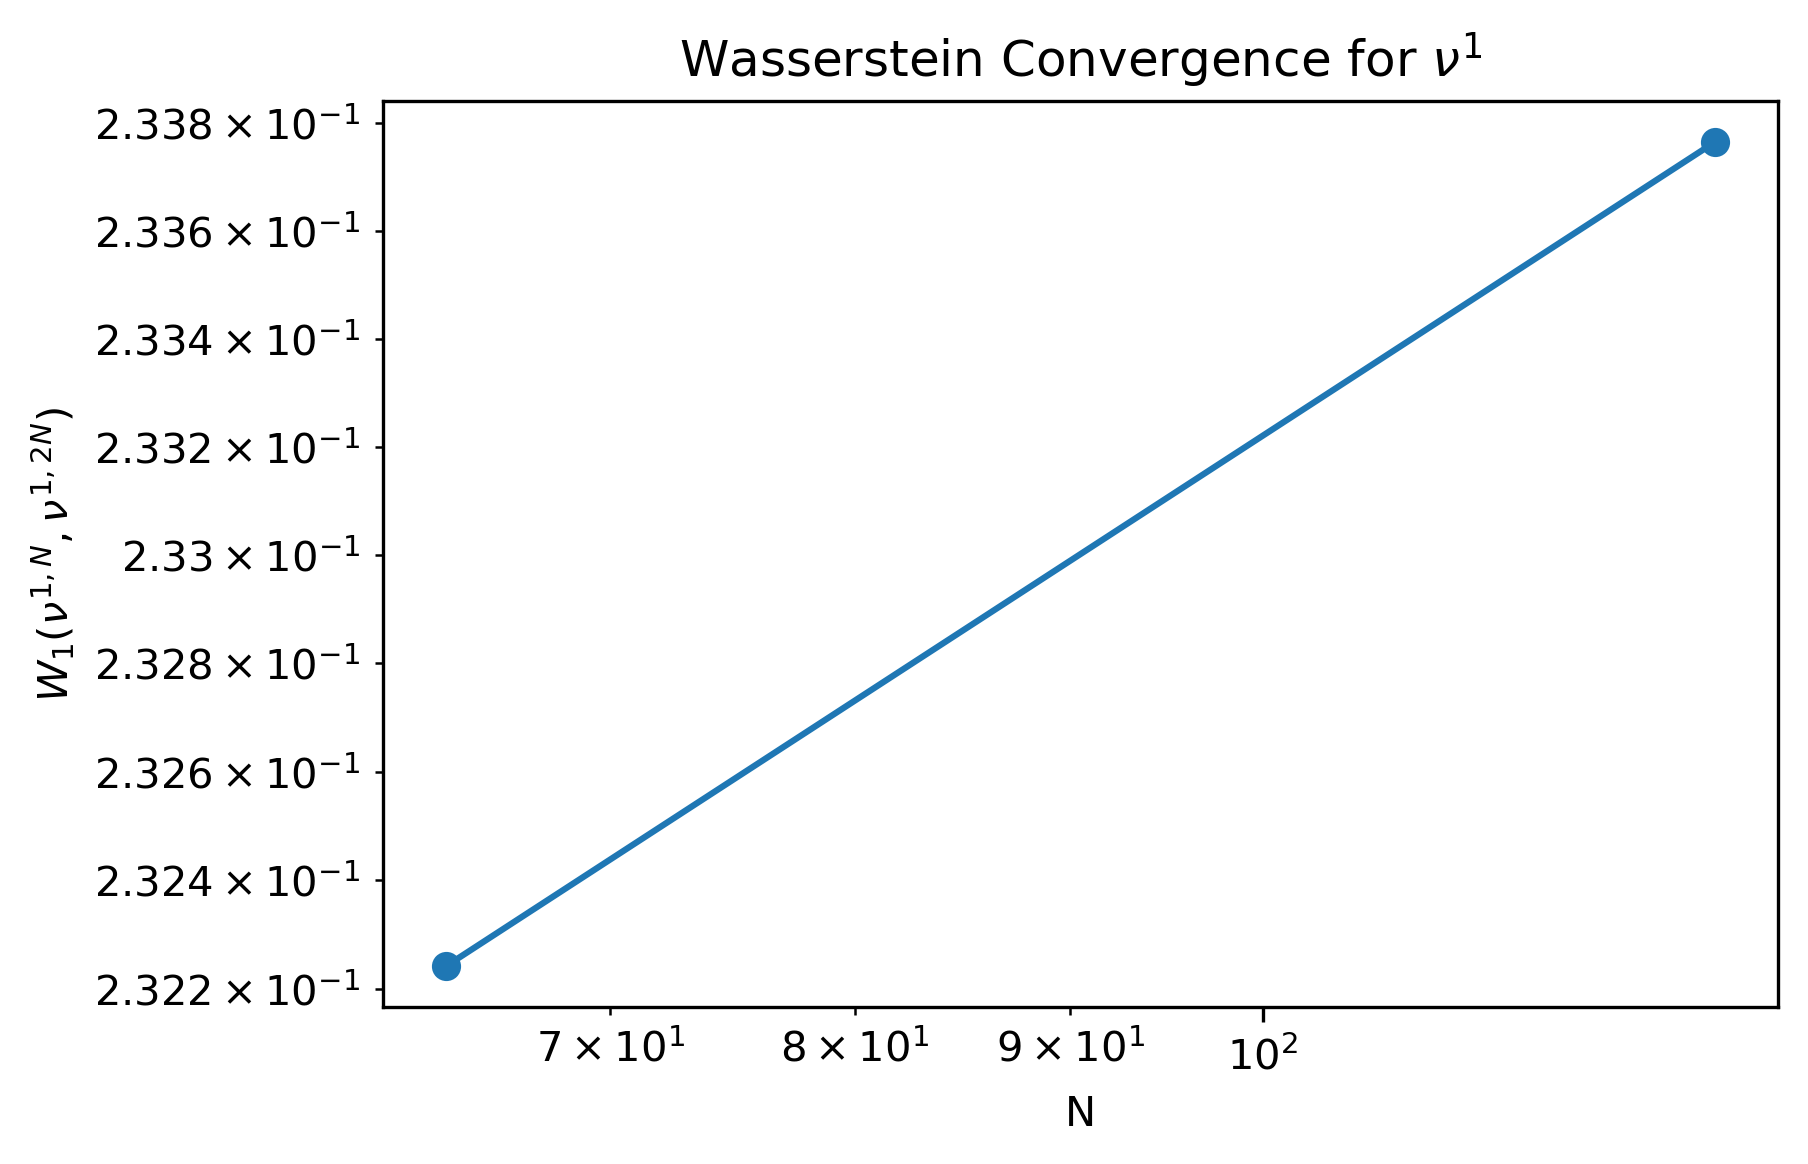

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 0.8920894731657172
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 0.899535976161786


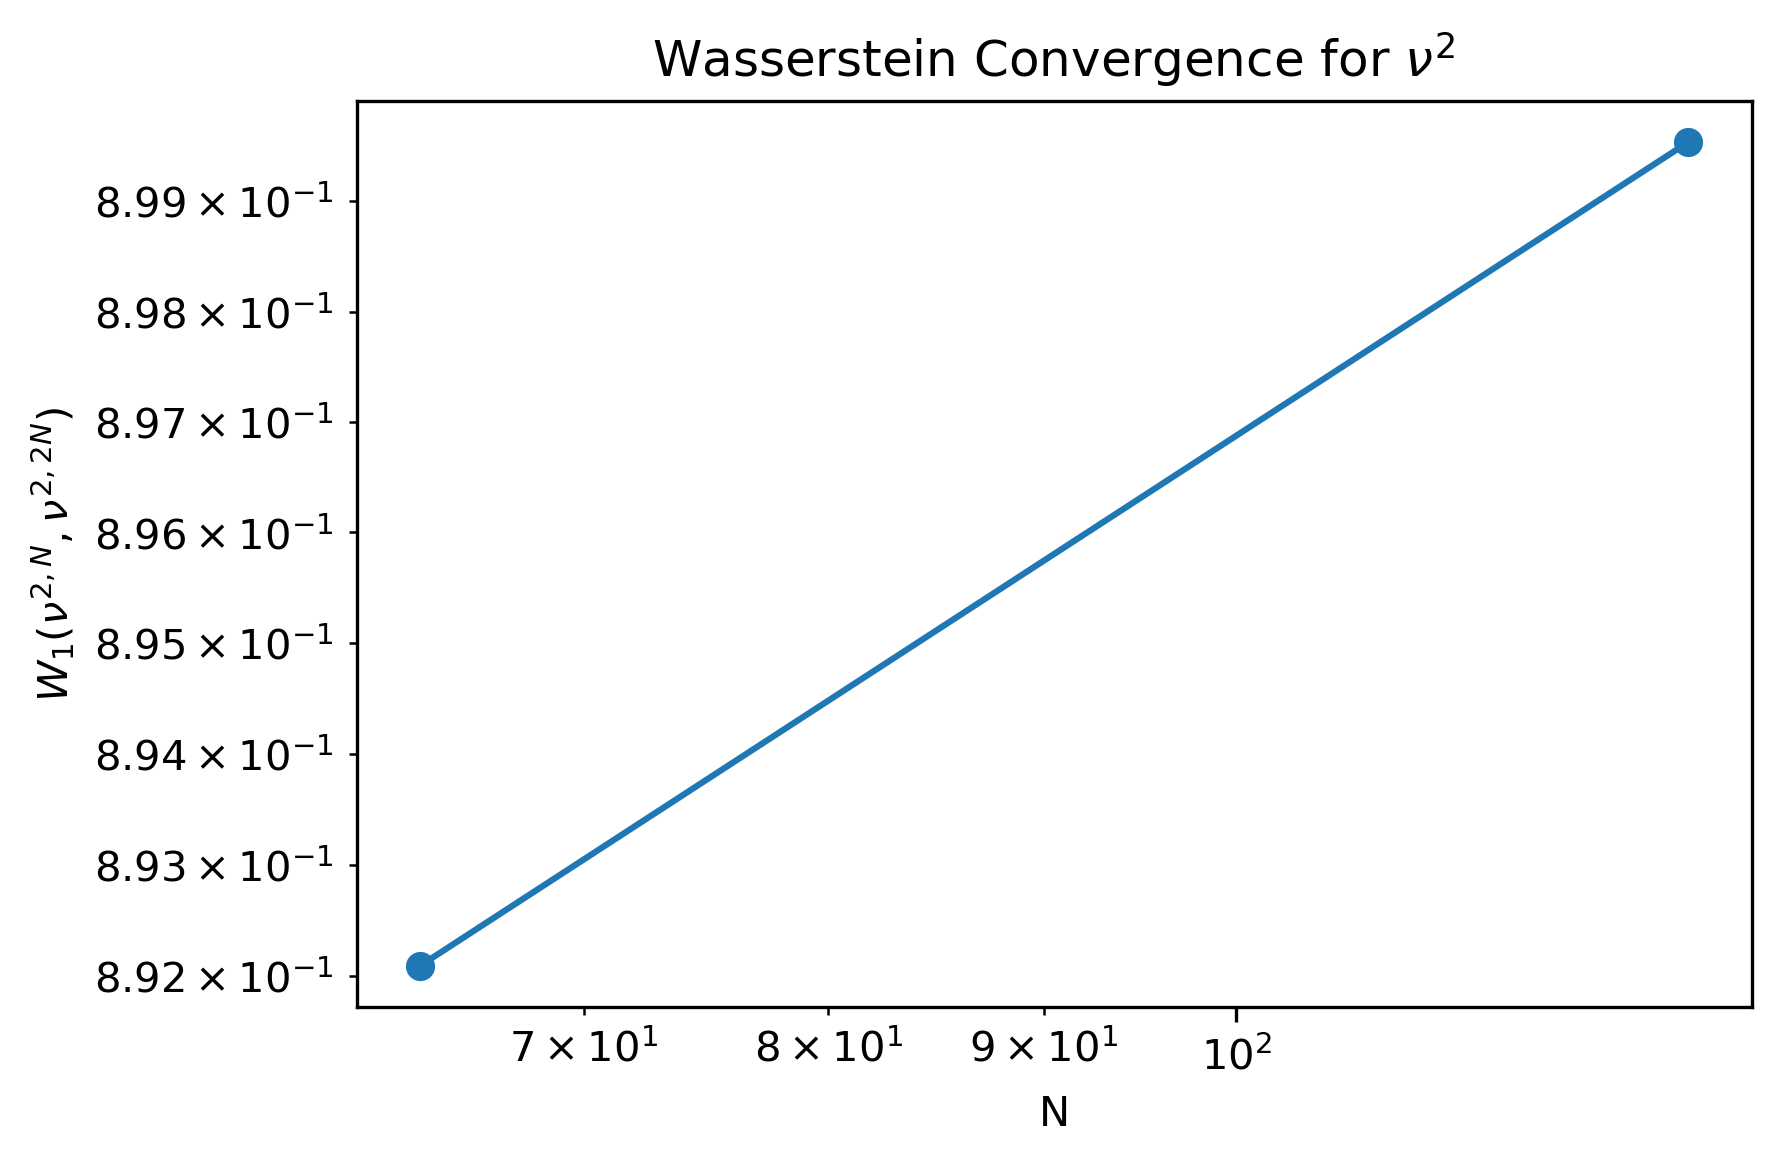

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.19128257922228653
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.18500262163256406


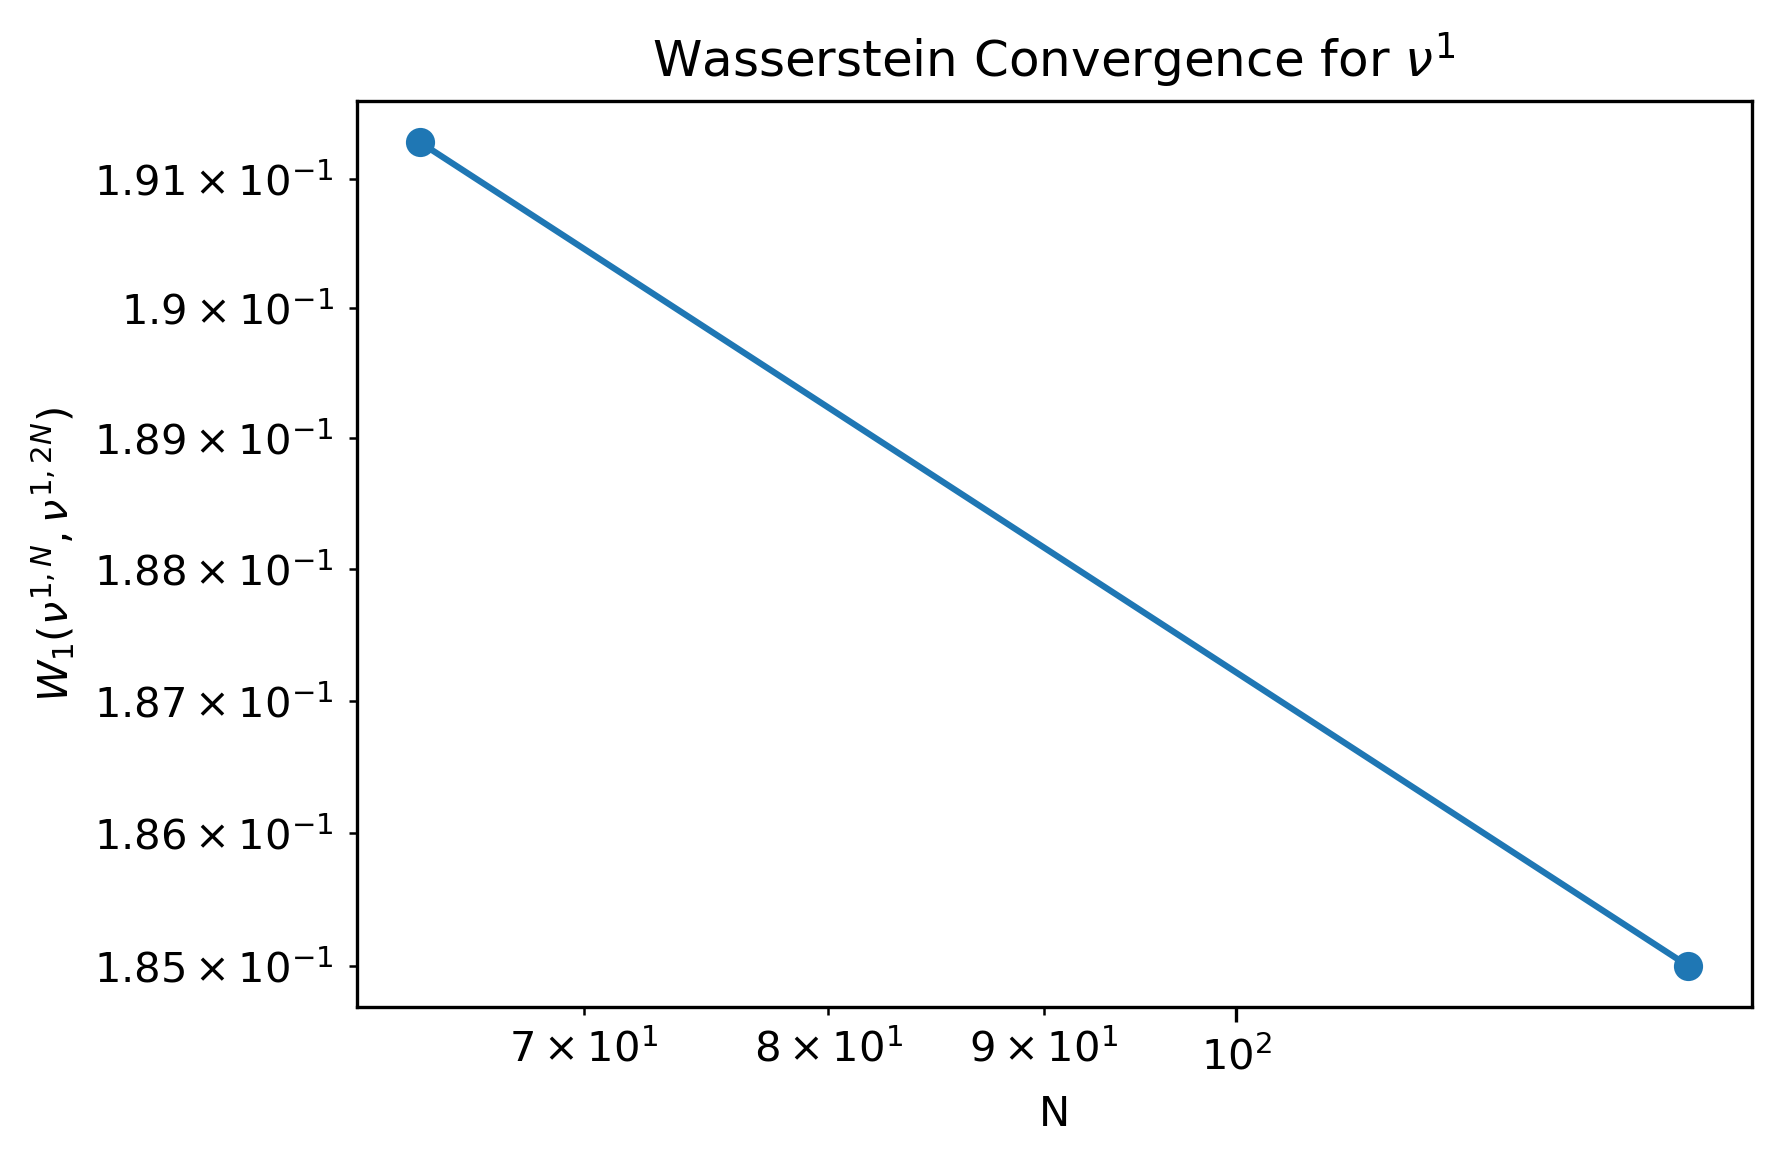

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 0.7417814990145648
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 0.7203135305593137


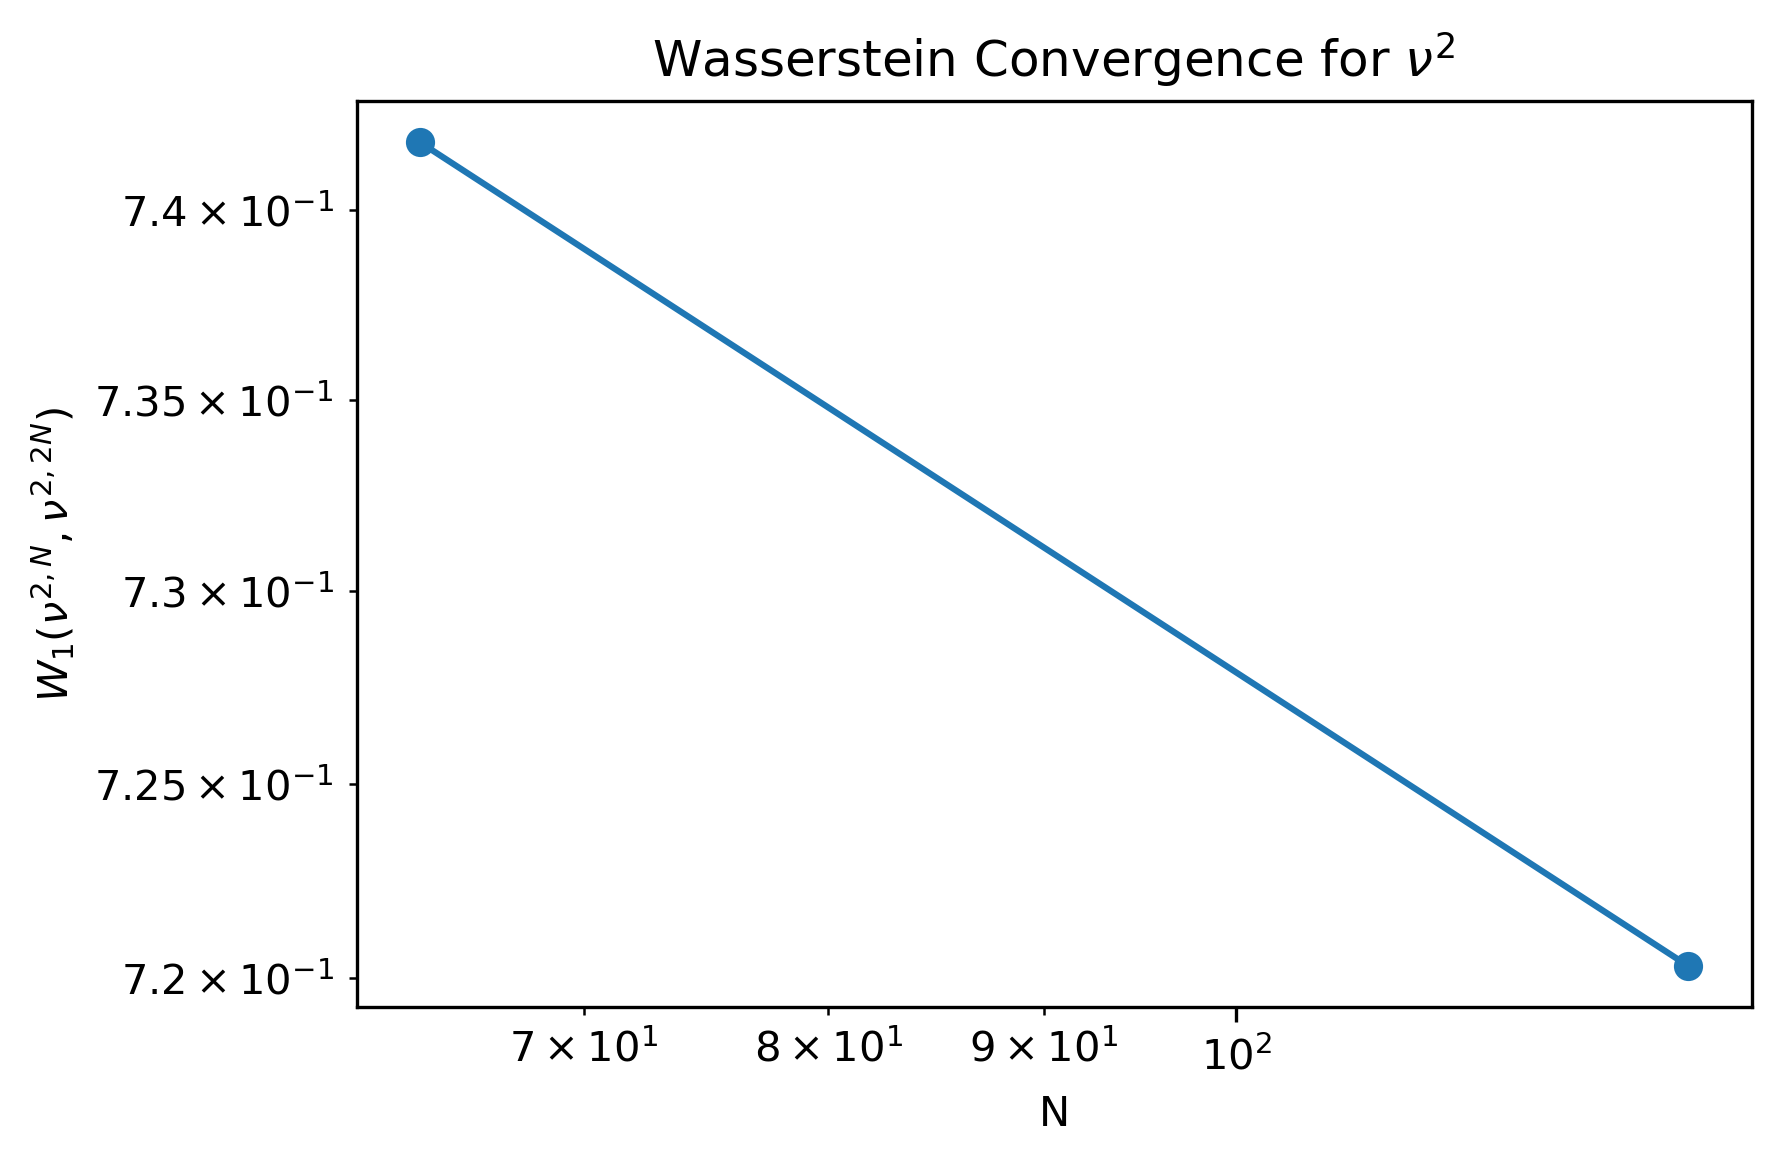

In [8]:
for H in [15, 50, 75]:
    for k in [1, 2]:
        plot_wasserstein([f'{experiment_folder}/bm_H{H}_N64',
                          f'{experiment_folder}/bm_H{H}_N128',
                          f'{experiment_folder}/bm_H{H}_N256'],
                         [64, 128, 256], k, 20, 10,
                         save_name=f'{experiment_folder}/bm_H{H}_wasserstein_{k}point.png')

# Wasserstein Convergence of Taylor Green Vortex

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.083760534939116
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.07765538761106291


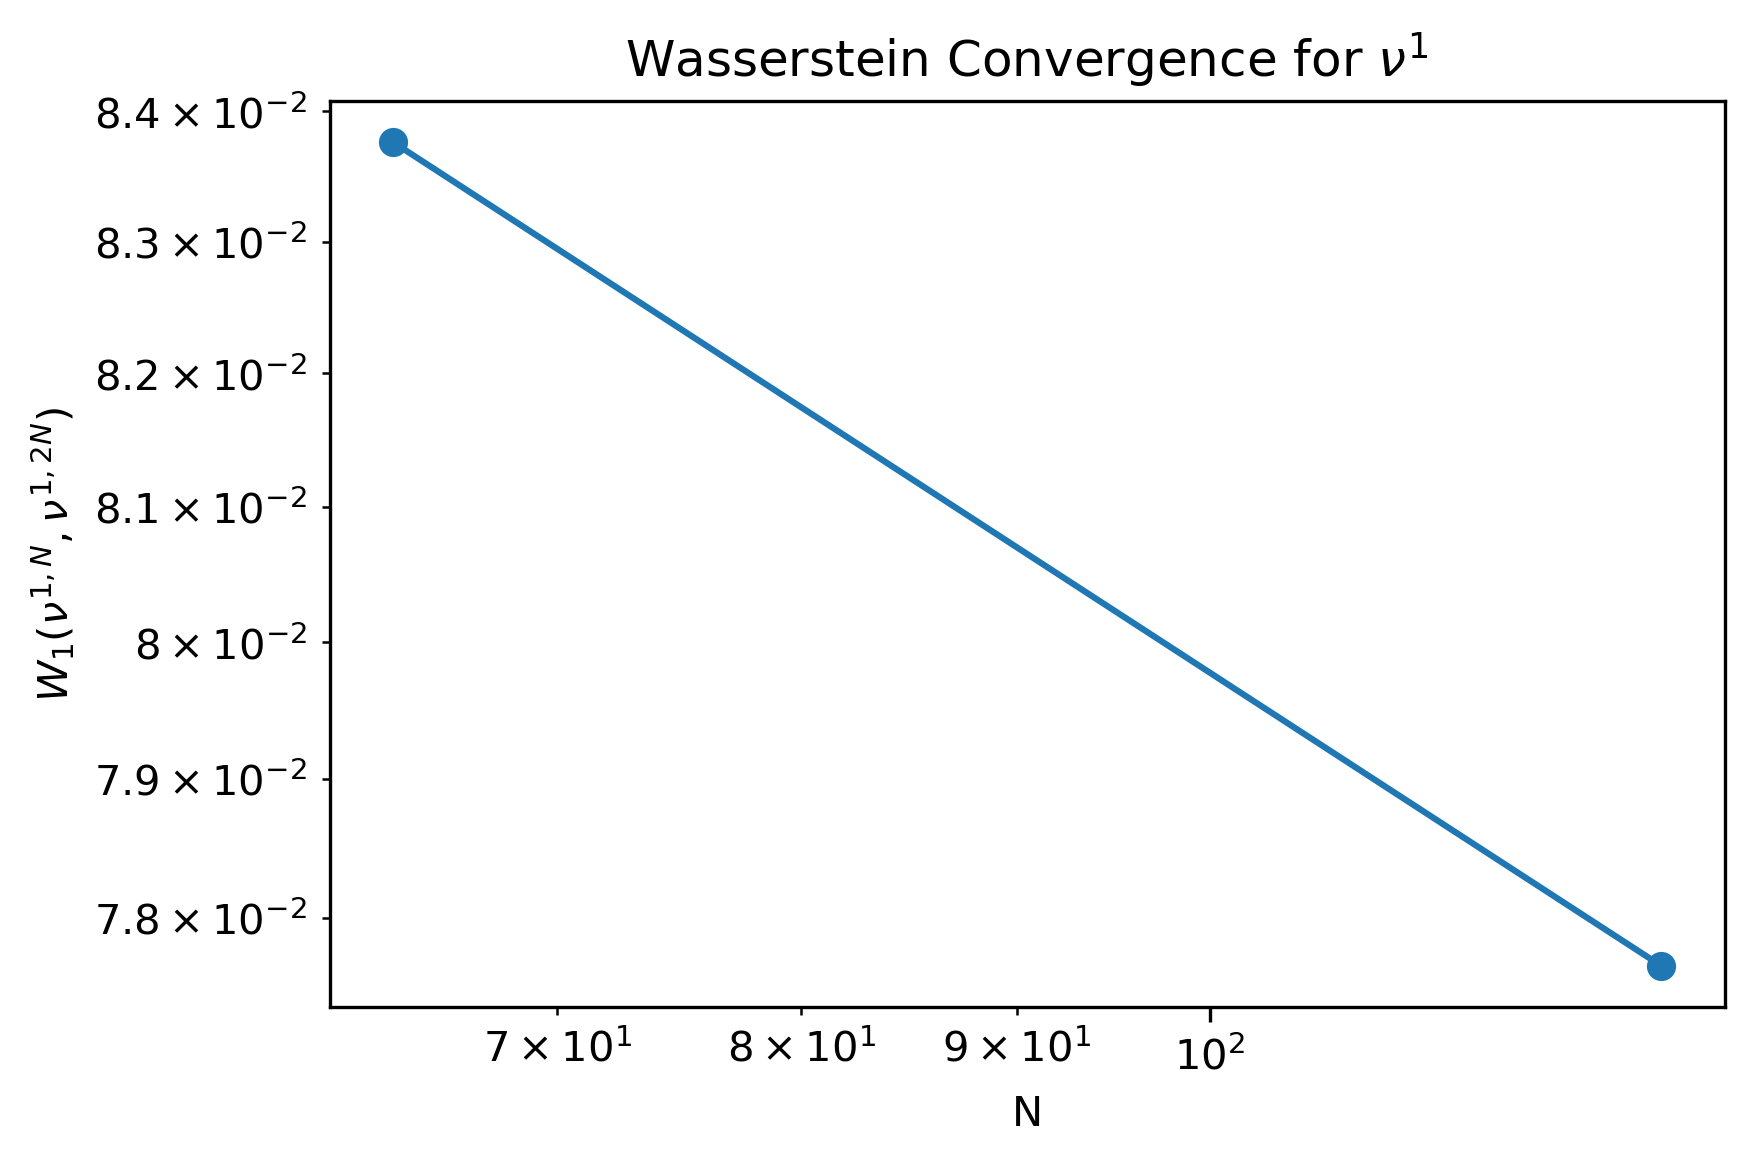

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 0.3251176836224773
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 0.3045872732115981


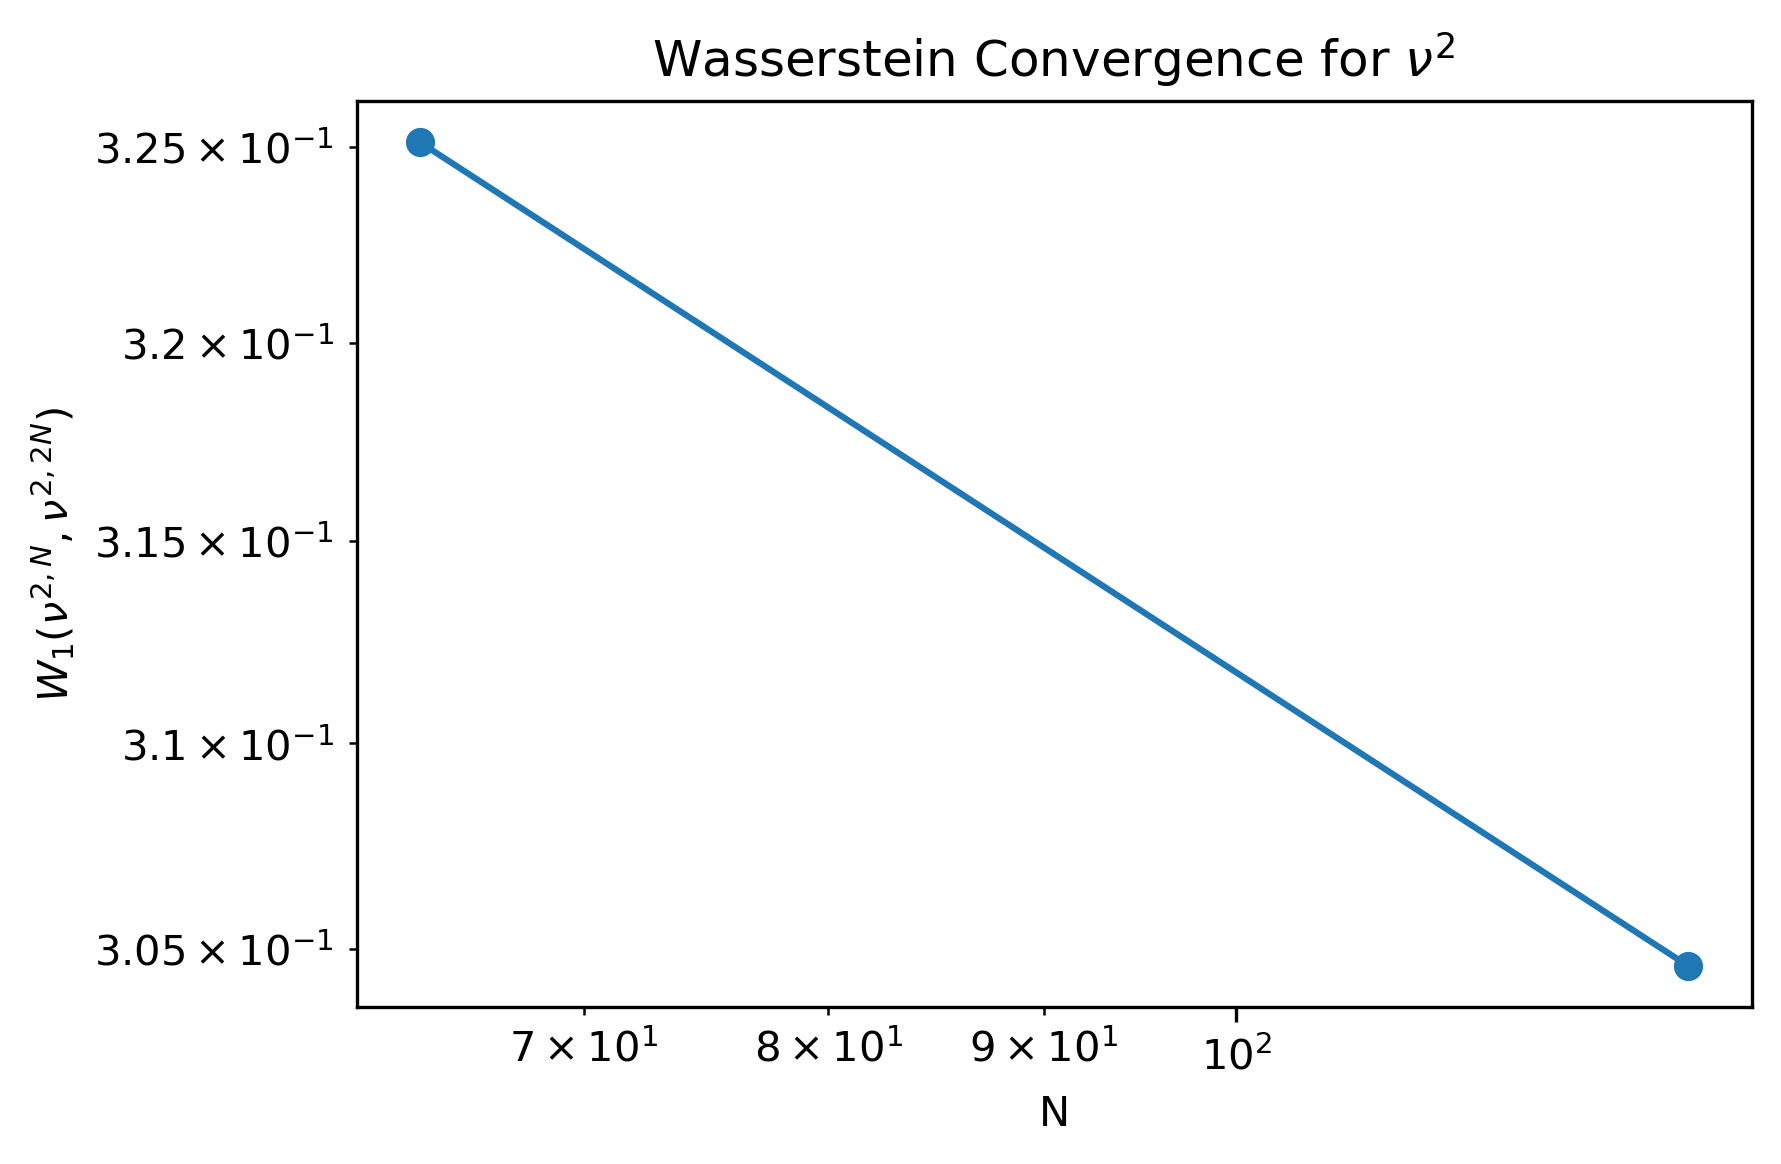

In [9]:
for k in [1, 2]:
    plot_wasserstein([f'{experiment_folder}/tg_N64',
                      f'{experiment_folder}/tg_N128',
                      f'{experiment_folder}/tg_N256'],
                     [64, 128, 256], k, 50, 10,
                     save_name=f'{experiment_folder}/tg_wasserstein_{k}point.png')

# Wasserstein Convergence of Discontinuous Shear Layer

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.163008075658232
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.1658409979347198


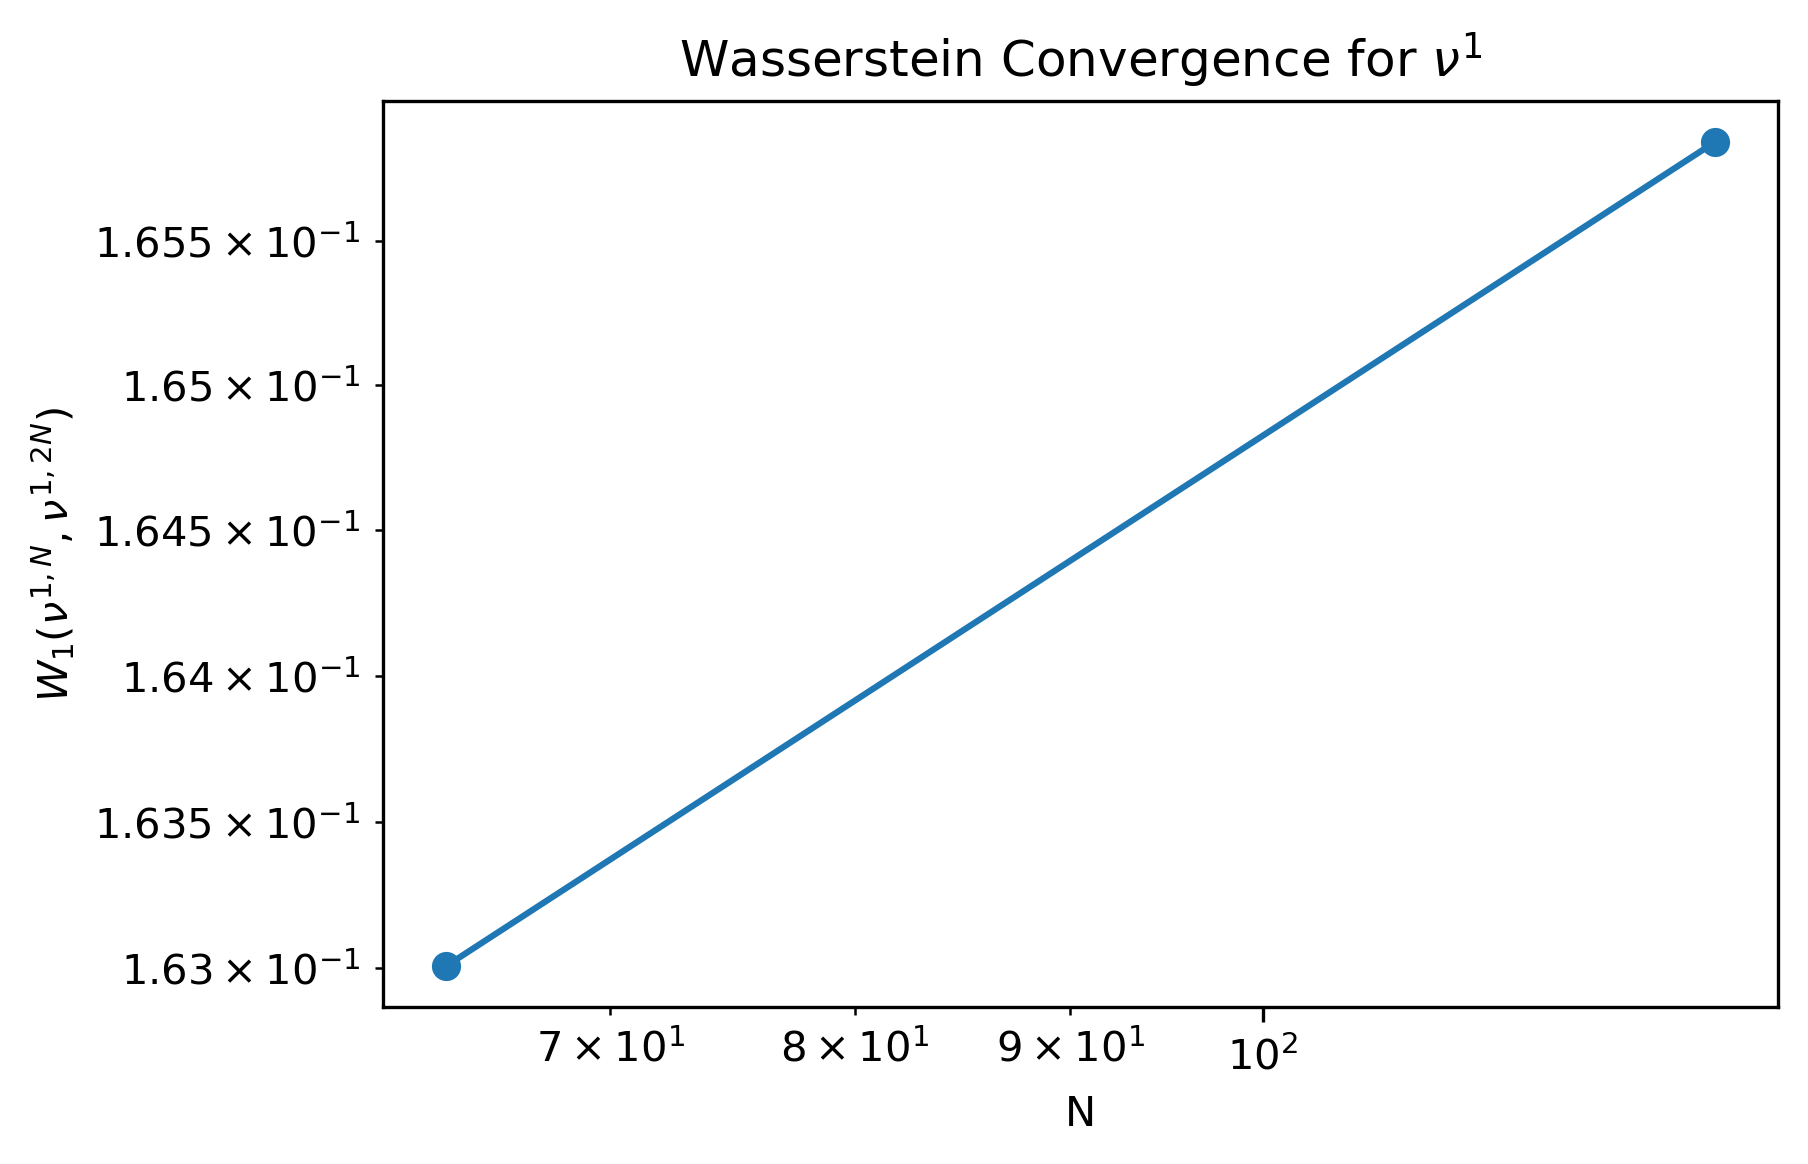

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 0.6429136171802693
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 0.6575942226462195


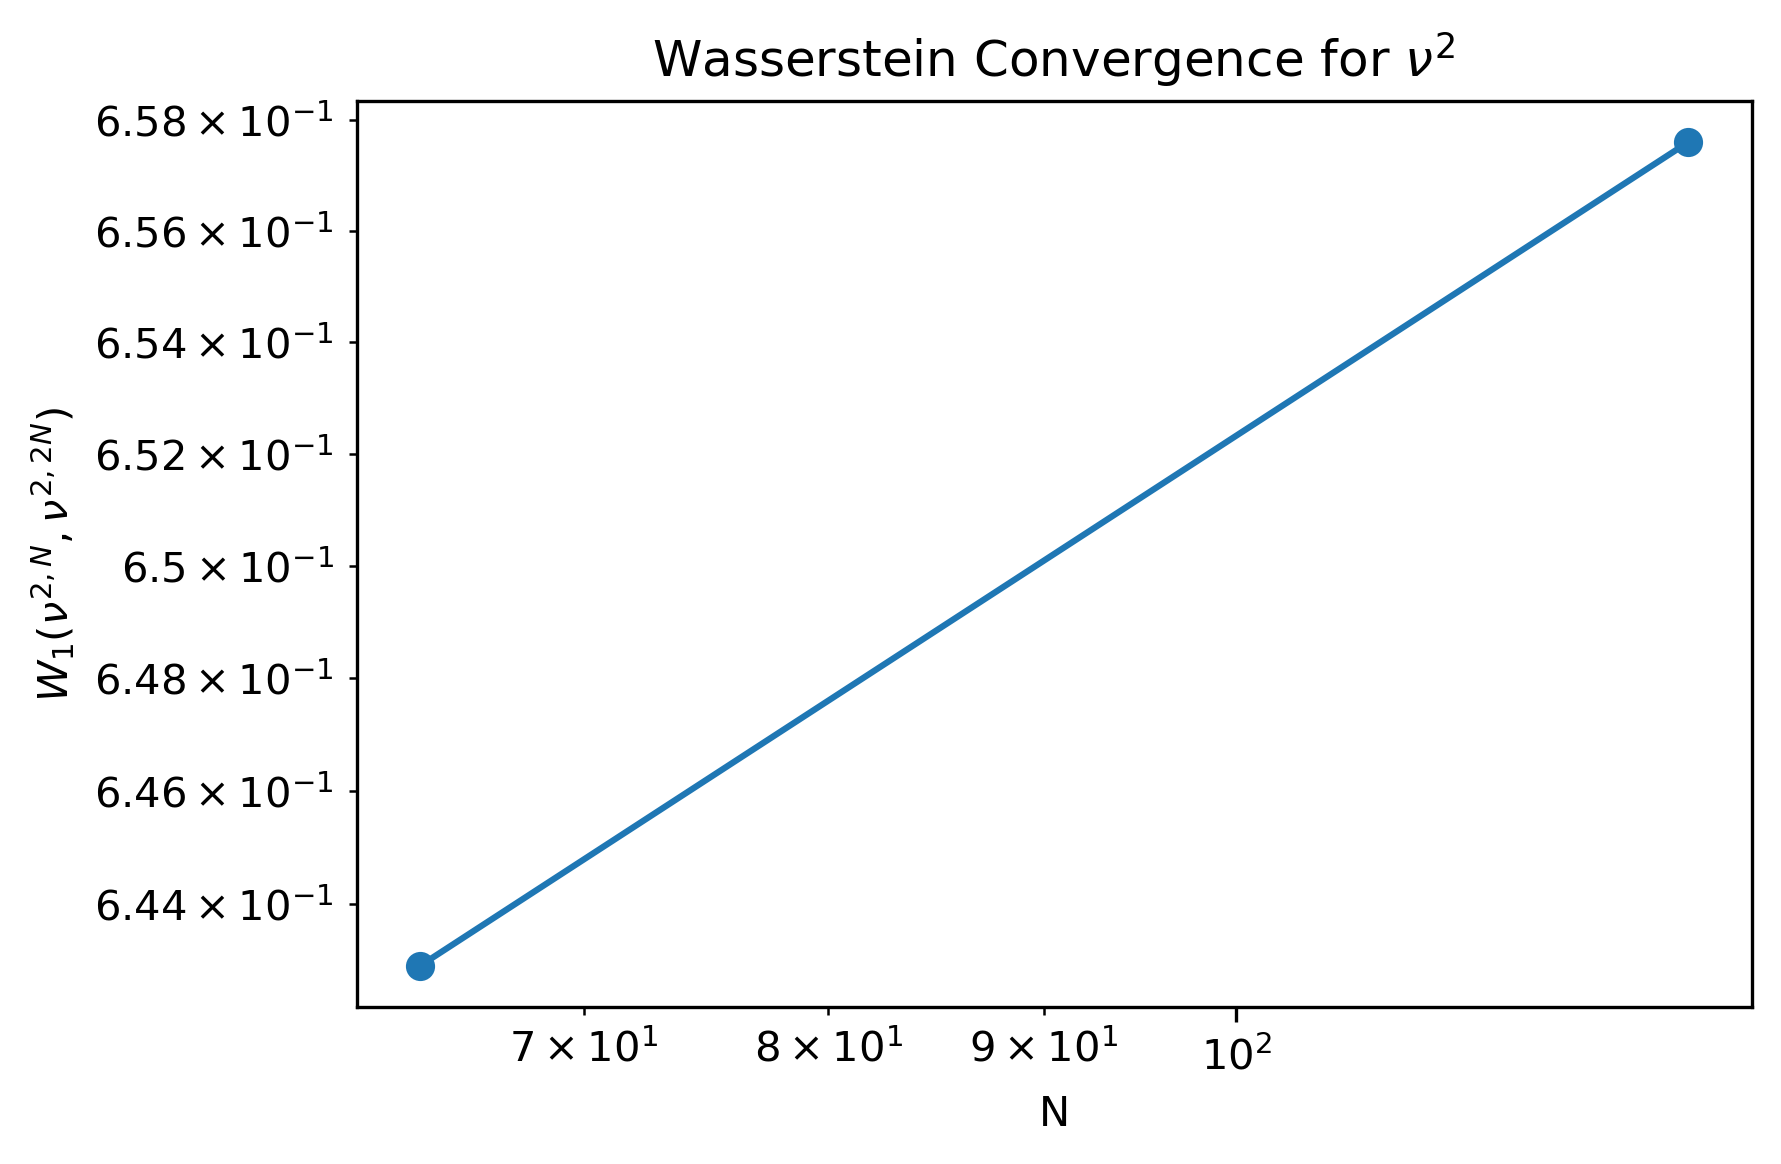

Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,64}, \nu^{1,128}) = 0.16719738625636088
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
Using chunksize=5 for 1000 points
W_1(\nu^{1,128}, \nu^{1,256}) = 0.17013668432911805


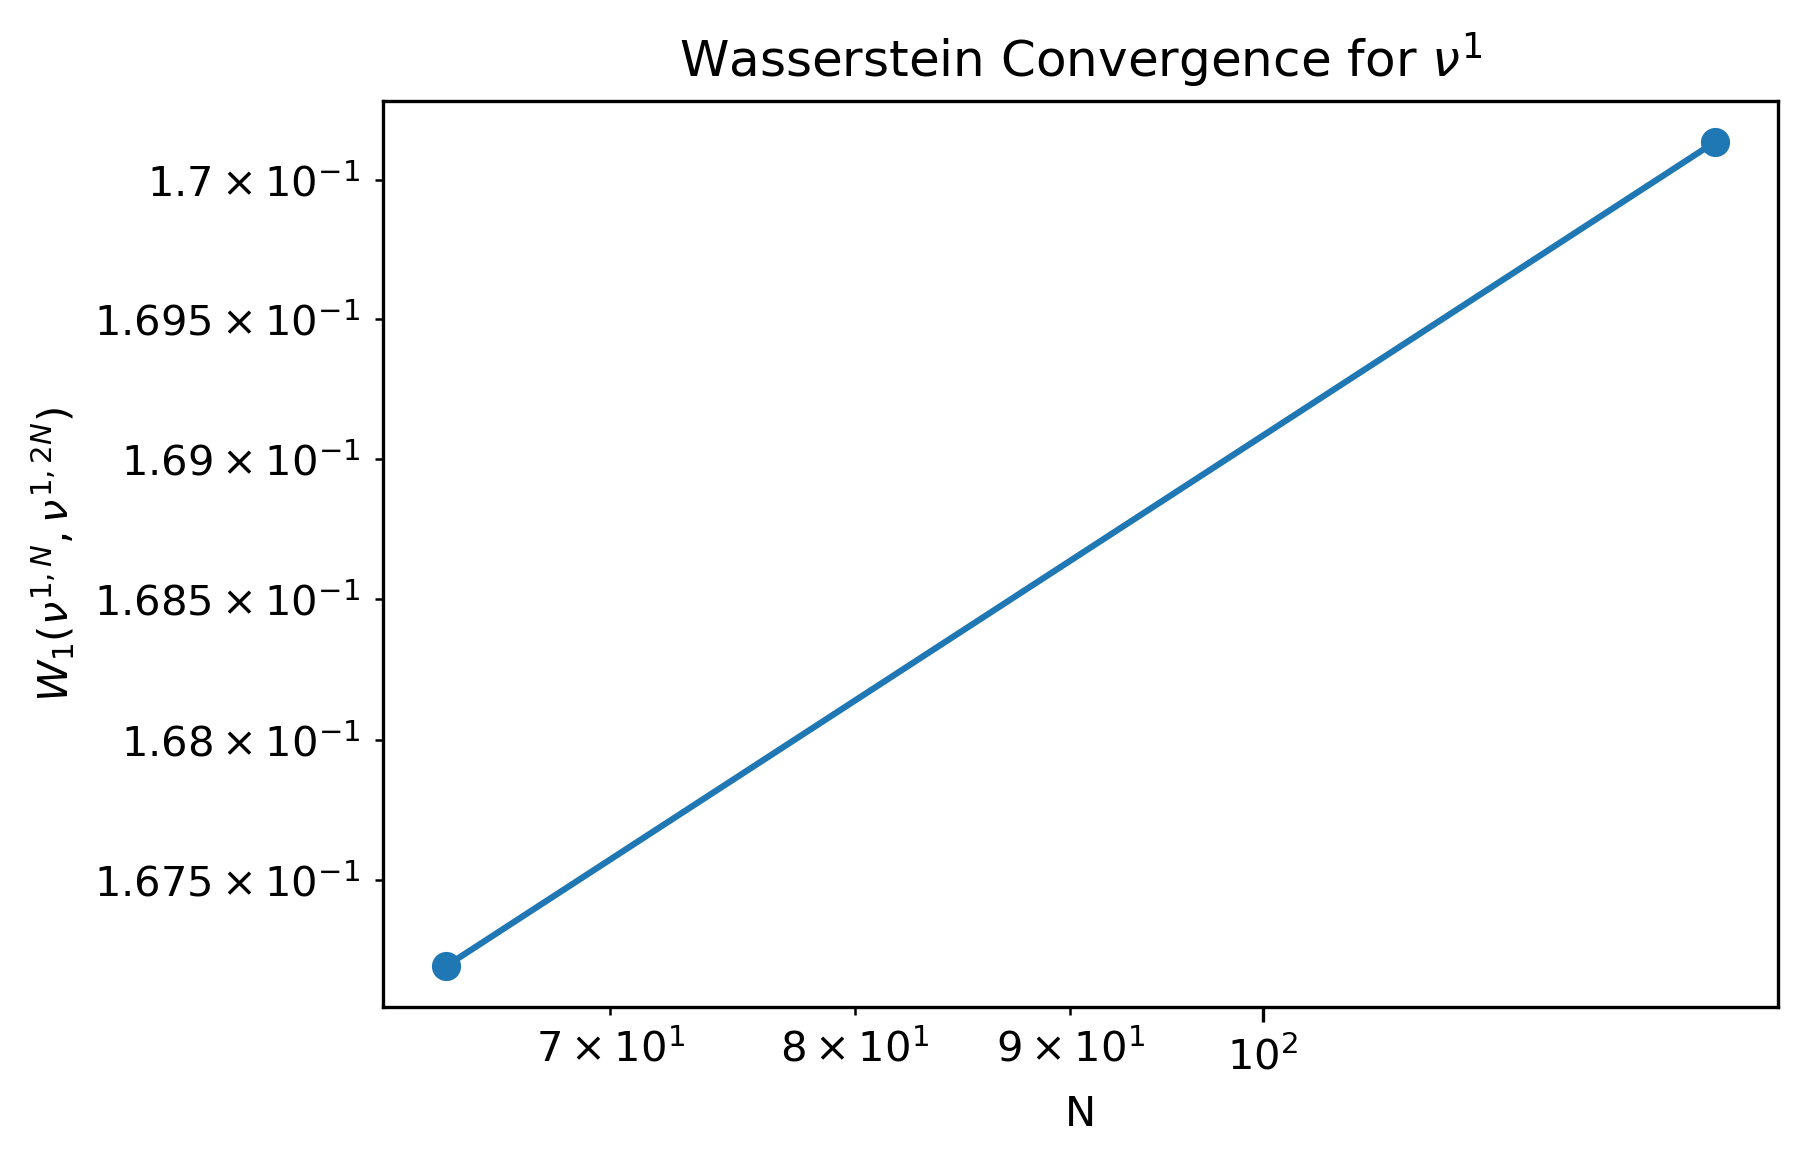

Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,64}, \nu^{2,128}) = 0.6564508074204504
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
Using chunksize=5208 for 1000000 points
W_1(\nu^{2,128}, \nu^{2,256}) = 0.6690772931197088


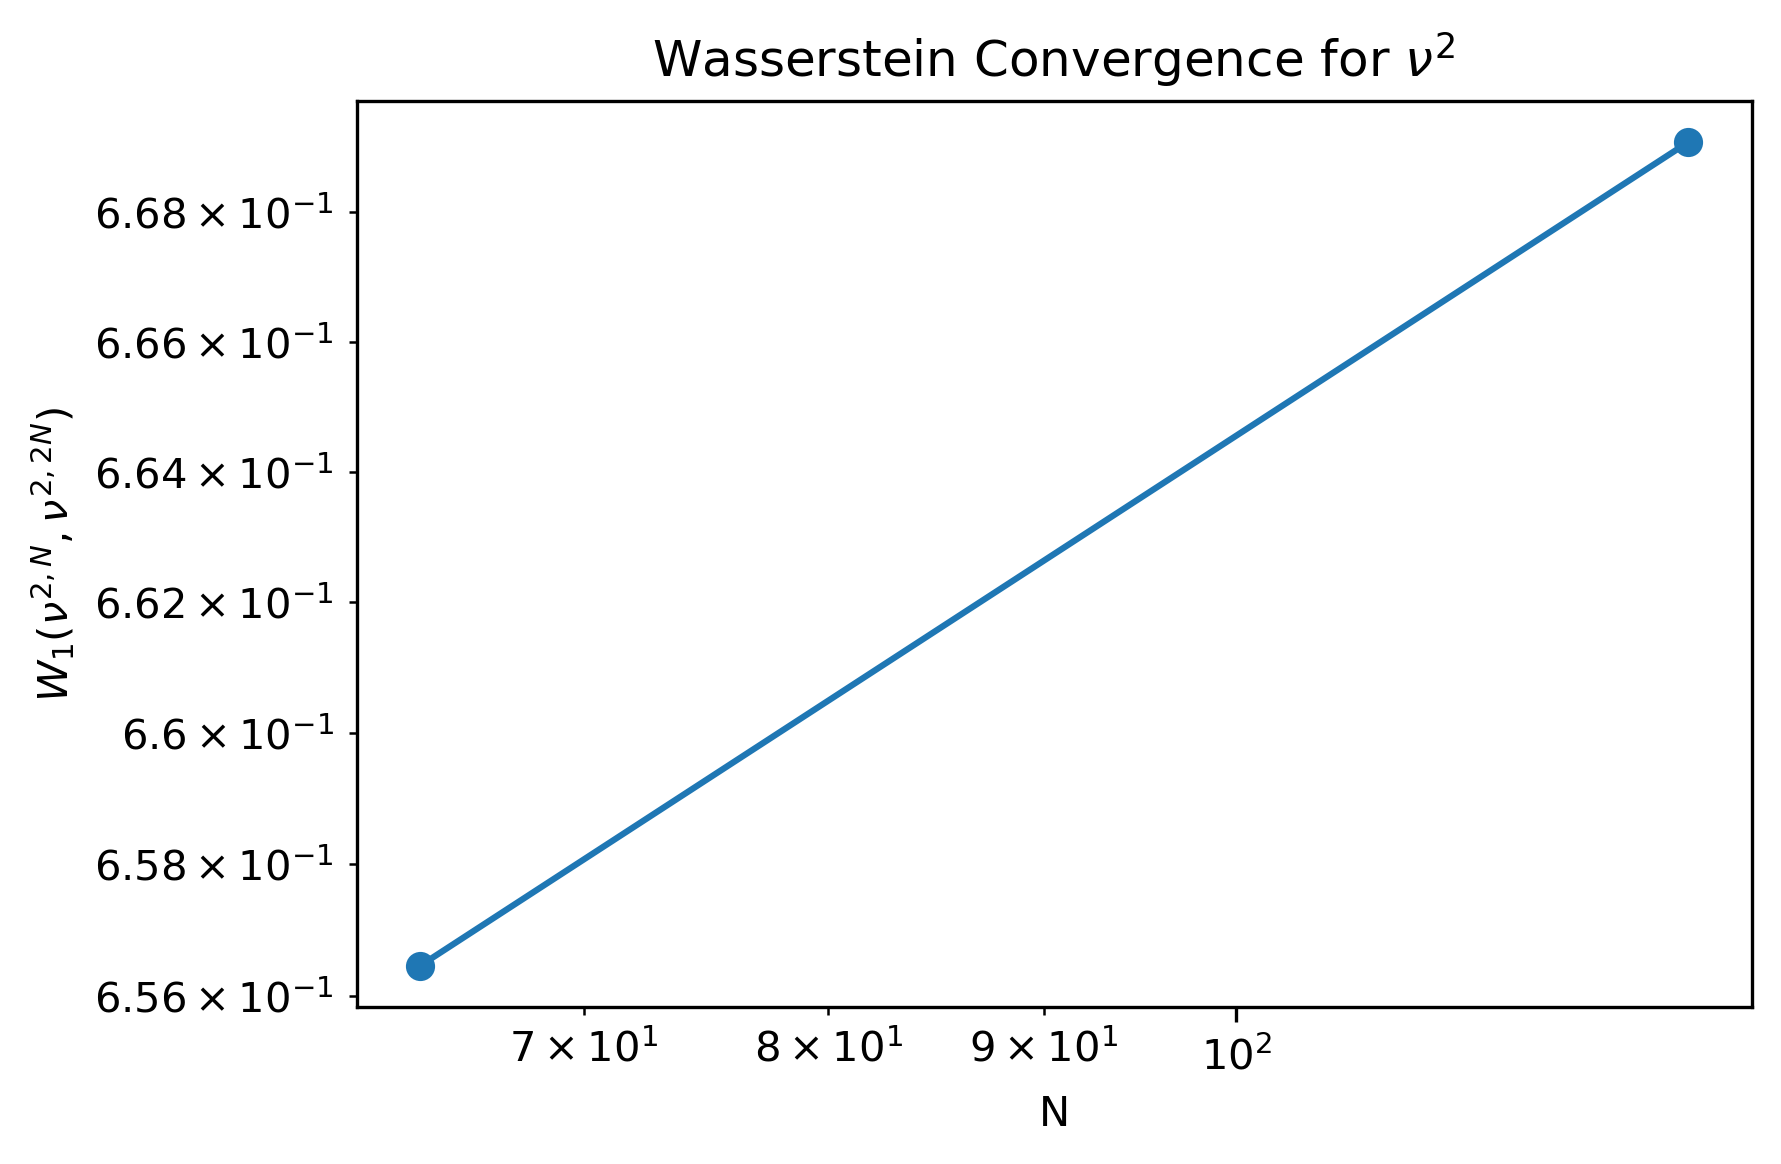

In [10]:
for rho in [0, 1]:
    for k in [1, 2]:
        plot_wasserstein([f'{experiment_folder}/dst_r{rho}_N64',
                          f'{experiment_folder}/dst_r{rho}_N128',
                          f'{experiment_folder}/dst_r{rho}_N256'],
                         [64, 128, 256], k, 50, 10,
                         save_name=f'{experiment_folder}/dst_r{rho}_wasserstein_{k}point.png')